In [1]:
# https://stackoverflow.com/questions/37890898/how-to-set-env-variable-in-jupyter-notebook
# %env PYTHONPATH=/export/fs04/a12/rhuang/k2/k2/python:$PYTHONPATH # for `import k2`
# %env PYTHONPATH=/export/fs04/a12/rhuang/k2/build/temp.linux-x86_64-cpython-38/lib/:$PYTHONPATH # for `import _k2`
# # export PYTHONPATH=/export/fs04/a12/rhuang/icefall_align/:$PYTHONPATH
# # export PYTHONPATH=/export/fs04/a12/rhuang/icefall/:$PYTHONPATH
# %env PYTHONPATH=/export/fs04/a12/rhuang/icefall_align2/:$PYTHONPATH

import sys
sys.path.append("/export/fs04/a12/rhuang/k2/k2/python")
sys.path.append("/export/fs04/a12/rhuang/k2/build/temp.linux-x86_64-cpython-38/lib/")
sys.path.append("/export/fs04/a12/rhuang/icefall_align2/")


In [58]:
import k2
from collections import defaultdict

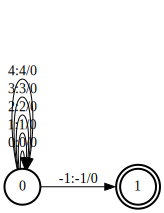

In [14]:
def self_loops(
    max_token: int,
):
    start_state = 0
    final_state = 1
    arcs = []
    for i in range(0, max_token + 1):
        arcs.append([start_state, start_state, i, i, 0])

    arcs.append([start_state, final_state, -1, -1, 0])
    arcs.append([final_state])

    arcs = sorted(arcs, key=lambda arc: arc[0])
    arcs = [[str(i) for i in arc] for arc in arcs]
    arcs = [" ".join(arc) for arc in arcs]
    arcs = "\n".join(arcs)

    fst = k2.Fsa.from_str(arcs, acceptor=False)
    # fst = k2.remove_epsilon(fst)  # Credit: Matthew W
    # fst = k2.expand_ragged_attributes(fst)
    return fst
  
a = self_loops(4)
k2.to_dot(a)

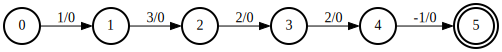

In [15]:
b = k2.linear_fsa([1,3,2,2])
k2.to_dot(b)

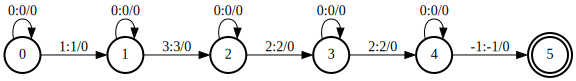

In [16]:
a.aux_labels = a.labels
b.aux_labels = b.labels
c = k2.compose(
  b, a, treat_epsilons_specially=True
)
k2.to_dot(c)
# c.draw('tmp.svg')

In [30]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

def remove_epsilons(c):
    c_str = k2.to_str_simple(c)
    # print(c_str)

    arcs = c_str.split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # print(arcs)
    # print(final_state)

    new_arcs = []
    for x, y in pairwise(arcs):
        assert x[0] == x[1]
        assert x[2] == x[3] == 0
        assert y[2] == y[3]
        if y[2] % 3 == 0:
            new_arcs.append(x)
        new_arcs.append(y)
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst

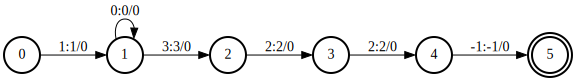

In [31]:
d = remove_epsilons(c)
k2.to_dot(d)

In [52]:
def ctc_topo_modified_no_blk(
    max_token: int,
    sil_id: int,
) -> k2.Fsa:
    '''
    This should produce the same topo as `k2.ctc_topo(max_token_id, modified=True)`
    '''
    print("Using my own version of `ctc_topo_modified`")
    num_tokens = max_token
    # assert (
    #     sil_id <= max_token
    # ), f"sil_id={sil_id} should be less or equal to max_token={max_token}"

    num_states = num_tokens + 2

    # ref: https://github.com/k2-fsa/icefall/blob/master/egs/librispeech/ASR/local/prepare_lang.py#L248

    start_state = 0
    final_state = num_states - 1
    arcs = []

    blk = 0
    eps = 0
    # arcs.append([start_state, start_state, blk, eps, 0])

    for i in range(1, max_token + 1):
        arcs.append([start_state, start_state, i, i, 0])

    for i in range(1, max_token + 1):
        cur_state = i  # state_id = token_id
        arcs.append([start_state, cur_state, i, i, 0])
        arcs.append([cur_state, cur_state, i, eps, 0])
        arcs.append([cur_state, start_state, i, eps, 0])

    arcs.append([start_state, final_state, -1, -1, 0])
    arcs.append([final_state])

    arcs = sorted(arcs, key=lambda arc: arc[0])
    arcs = [[str(i) for i in arc] for arc in arcs]
    arcs = [" ".join(arc) for arc in arcs]
    arcs = "\n".join(arcs)

    fst = k2.Fsa.from_str(arcs, acceptor=False)
    # fst = k2.remove_epsilon(fst)  # Credit: Matthew W
    # fst = k2.expand_ragged_attributes(fst)
    return fst

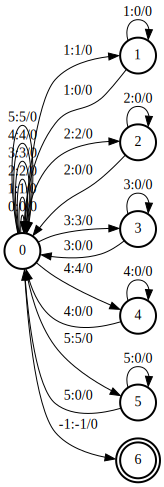

In [54]:
# topo = ctc_topo_modified_no_blk(5, 5)
topo = k2.ctc_topo(5, modified=True)
k2.to_dot(topo)

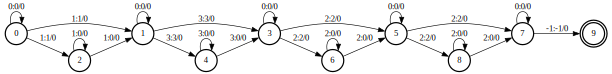

In [50]:
c = k2.arc_sort(c)
topo = k2.arc_sort(topo)
c_topo = k2.compose(
  topo, c, treat_epsilons_specially=False
)
k2.to_dot(c_topo)

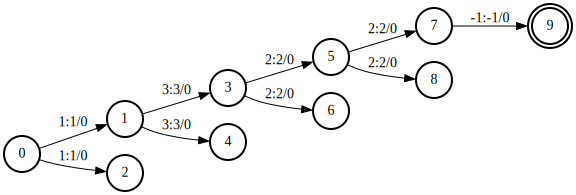

In [49]:
b = k2.arc_sort(b)
topo = k2.arc_sort(topo)
b_topo = k2.compose(
  topo, b, treat_epsilons_specially=False
)
k2.to_dot(b_topo)

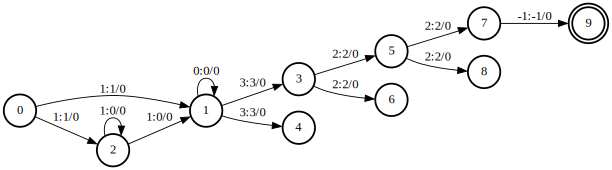

In [55]:
d = k2.arc_sort(d)
topo = k2.arc_sort(topo)
d_topo = k2.compose(
  topo, d, treat_epsilons_specially=False
)
k2.to_dot(d_topo)

In [70]:
def remove_intra_word_blk(decoding_graph, start_tokens, flag=True):
    c_str = k2.to_str_simple(decoding_graph)
    # print(c_str)

    arcs = c_str.split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # print(arcs)
    # print(final_state)

    if flag is False:
        new_arcs = arcs
        new_arcs.append([final_state])

        new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
        new_arcs = [[str(i) for i in arc] for arc in new_arcs]
        new_arcs = [" ".join(arc) for arc in new_arcs]
        new_arcs = "\n".join(new_arcs)

        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        return fst

    state_arcs = defaultdict(list)
    for arc in arcs:
        state_arcs[arc[0]].append(arc)

    new_arcs = []
    for state, arc_list in state_arcs.items():
        eps_self_loop = None
        should_keep_self_loop = False
        for i, arc in enumerate(arc_list):
            if arc[0] == arc[1] and arc[2] == arc[3] == 0:
                eps_self_loop = i
            if arc[2] in start_tokens:
                should_keep_self_loop = True
        
        if eps_self_loop is None or should_keep_self_loop:
            new_arcs.extend(arc_list)
        else:
            # print(f"state {state} should remove an arc {eps_self_loop}: {arc_list[eps_self_loop]}")
            new_arcs.extend(arc_list[:eps_self_loop])
            new_arcs.extend(arc_list[eps_self_loop+1:])
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst

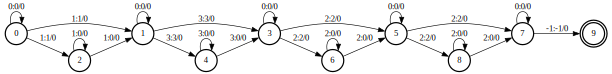

In [73]:
c_topo_ = remove_intra_word_blk(c_topo, {3}, flag=False)
k2.to_dot(c_topo_)

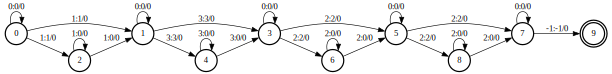

In [72]:
k2.to_dot(c_topo)